EE633 Homework1 \\
20225358 최은성 \\
Problem 6

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import poisson
import sys

In [207]:
class jack:
  @staticmethod
  def credit():
    return 10
  @staticmethod
  def move_rew():
    return -2
  @staticmethod
  def second_rew():
    return -4
  @staticmethod
  def max_car():
    return 20
  @staticmethod
  def gamma():
    return 0.9

In [194]:
class poisson_dist:
  def __init__(self, lambda_):
    self.lambda_ = lambda_
    self.alpha = 0;
    self.vals = {}
    epsilon = 0.01
    state = 1
    add = 0

    while(1):
      if state == 1:
        temp = poisson.pmf(self.alpha, self.lambda_)
        if temp <= epsilon:
          self.alpha += 1
        else:
          self.vals[self.alpha] = temp
          self.beta = self.alpha + 1
          state = 2
          add += temp
      elif state == 2:
        temp = poisson.pmf(self.beta, self.lambda_)
        if temp > epsilon:
          self.vals[self.beta] = temp
          self.beta += 1
          add += temp
        else:
          break

    add_value = (1-add)/(self.beta-self.alpha)
    
    for key in self.vals:
      self.vals[key] += add_value

In [195]:
class loc:
  def __init__(self, req, ret):
    self.alpha = req
    self.beta = ret
    self.poisson_alp = poisson_dist(self.alpha)
    self.poisson_beta = poisson_dist(self.beta)

locA = loc(3,3)
locB = loc(4,2)

In [196]:
value = np.zeros((jack.max_car()+1, jack.max_car()+1))
policy = value.copy().astype(int)

In [197]:
def expect_reward(s,a):
  global value
  psi = 0
  psi = psi + jack.move_rew()*abs(a)
  s_prime = [max(min(s[0] - a, jack.max_car()),0), max(min(s[1] + a, jack.max_car()),0)]

  for locA_alp in range(locA.poisson_alp.alpha, locA.poisson_alp.beta):  
    for locA_beta in range(locA.poisson_beta.alpha, locA.poisson_beta.beta):
      for locB_alp in range(locB.poisson_alp.alpha, locB.poisson_alp.beta):
        for locB_beta in range(locB.poisson_beta.alpha, locB.poisson_beta.beta):
          xi = locA.poisson_alp.vals[locA_alp] * locB.poisson_alp.vals[locB_alp] * locA.poisson_beta.vals[locA_beta] * locB.poisson_beta.vals[locB_beta]

          valid_req_A = min(s_prime[0], locA_alp)
          valid_req_B = min(s_prime[1], locB_alp)
          reward = (valid_req_A + valid_req_B)*jack.credit()

          s_p = [0,0]
          s_p[0] = max(min(s_prime[0] - valid_req_A + locA_beta, jack.max_car()),0)
          s_p[1] = max(min(s_prime[1] - valid_req_B + locB_beta, jack.max_car()),0)

          psi += xi * (reward + jack.gamma() * value[s_p[0]][s_p[1]])
  return  psi

In [212]:
def expect_reward_2(s,a):
  global value
  psi = 0
  s_prime = [max(min(s[0] - a, jack.max_car()),0), max(min(s[1] + a, jack.max_car()),0)]

  if a <= 0:
      psi = psi + jack.move_rew() * abs(a)
  else:
      psi = psi + jack.move_rew() * (a - 1)
  if s_prime[0] > 10:
      psi += jack.second_rew()
  if s_prime[1] > 10:
      psi += jack.second_rew()

  for locA_alp in range(locA.poisson_alp.alpha, locA.poisson_alp.beta):  
    for locA_beta in range(locA.poisson_beta.alpha, locA.poisson_beta.beta):
      for locB_alp in range(locB.poisson_alp.alpha, locB.poisson_alp.beta):
        for locB_beta in range(locB.poisson_beta.alpha, locB.poisson_beta.beta):
          xi = locA.poisson_alp.vals[locA_alp] * locB.poisson_alp.vals[locB_alp] * locA.poisson_beta.vals[locA_beta] * locB.poisson_beta.vals[locB_beta]

          valid_req_A = min(s_prime[0], locA_alp)
          valid_req_B = min(s_prime[1], locB_alp)
          reward = (valid_req_A + valid_req_B)*jack.credit()

          s_p = [0,0]
          s_p[0] = max(min(s_prime[0] - valid_req_A + locA_beta, jack.max_car()),0)
          s_p[1] = max(min(s_prime[1] - valid_req_B + locB_beta, jack.max_car()),0)

          psi += xi * (reward + jack.gamma() * value[s_p[0]][s_p[1]])
  return  psi

In [198]:
def policy_eval():
  global value
  epsilon = policy_eval.epsilon
  print('epsilon = ', epsilon)
  policy_eval.epsilon *= 0.1
  while(1):
    delta = 0
    for i in range(value.shape[0]):
      for j in range(value.shape[1]):
        val_pre = value[i][j]
        value[i][j] = expect_reward([i,j], policy[i][j])
        delta = max(delta, abs(value[i][j] - val_pre))
        sys.stdout.flush()
    print(delta)
    sys.stdout.flush()
    if epsilon > delta:
      break
policy_eval.epsilon = 50

In [213]:
def policy_eval_2():
  global value
  epsilon = policy_eval.epsilon
  print('epsilon = ', epsilon)
  policy_eval.epsilon *= 0.1
  while(1):
    delta = 0
    for i in range(value.shape[0]):
      for j in range(value.shape[1]):
        val_pre = value[i][j]
        value[i][j] = expect_reward_2([i,j], policy[i][j])
        delta = max(delta, abs(value[i][j] - val_pre))
        sys.stdout.flush()
    print(delta)
    sys.stdout.flush()
    if epsilon > delta:
      break

In [200]:
def policy_imp():
  global policy
  stability = True
  for i in range(value.shape[0]):
    for j in range(value.shape[1]):
      act_pre = policy[i][j]
      act_val_m = None
      act_m = None

      tau1to2 = min(i,5)
      tau2to1 = -min(j,5)

      for a in range(tau2to1,tau1to2+1):
        sigma = expect_reward([i,j],a)
        if act_val_m == None:
          act_val_m = sigma
          act_m = a
        elif act_val_m < sigma:
          act_val_m = sigma
          act_m = a
      
      policy[i][j] = act_m

      if act_pre != policy[i][j]:
        stability = False
  return stability

In [216]:
def policy_imp_2():
  global policy
  stability = True
  for i in range(value.shape[0]):
    for j in range(value.shape[1]):
      act_pre = policy[i][j]
      act_val_m = None
      act_m = None

      tau1to2 = min(i,5)
      tau2to1 = -min(j,5)

      for a in range(tau2to1,tau1to2+1):
        sigma = expect_reward_2([i,j],a)
        if act_val_m == None:
          act_val_m = sigma
          act_m = a
        elif act_val_m < sigma:
          act_val_m = sigma
          act_m = a
      
      policy[i][j] = act_m

      if act_pre != policy[i][j]:
        stability = False
  return stability

In [201]:
def policy_plt():
    pol_plot = sb.heatmap(policy, linewidth=0.5)
    pol_plot.invert_yaxis()
    plt.title("Policy")
    plt.ylabel("Cars at Location 1")
    plt.xlabel("Cars at Location 2")
    plt.show()
    
def value_plt():
    val_plot = sb.heatmap(value, linewidth=0.5)
    val_plot.invert_yaxis()
    plt.title("Value Function")
    plt.ylabel("Cars at Location 1")
    plt.xlabel("Cars at Location 2")
    plt.show()

Example 4.2

epsilon =  50
190.74226674318575
132.32881386079364
89.66201097313672
67.0977371088774
53.223562246983875
41.381416001991624


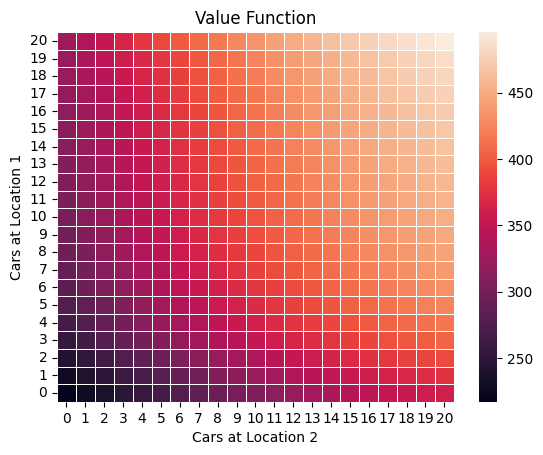

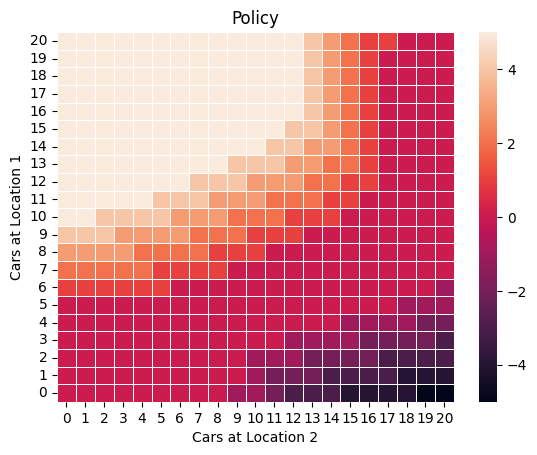

epsilon =  5.0
108.30002833852956
28.974428595453332
23.301431489076947
20.45232109391668
17.305046535861663
14.35883699154681
11.83071856682335
9.727345084820115
7.992788393132798
6.565837073517741
5.392905074620273
4.429149938857222


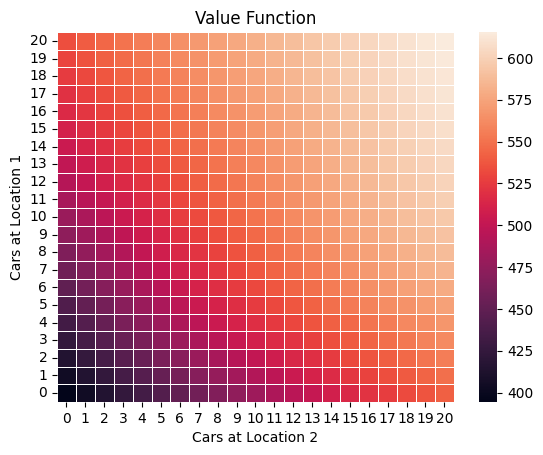

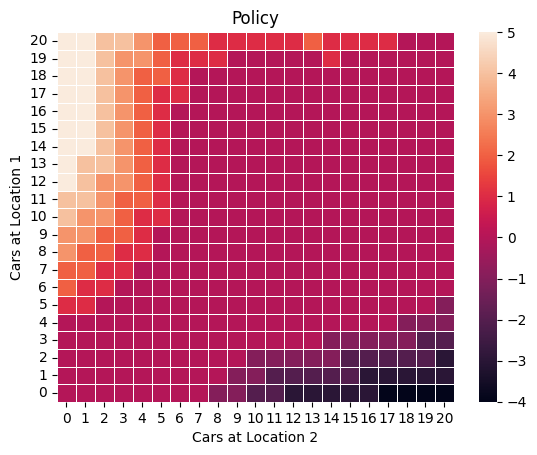

epsilon =  0.5
5.277987792396857
3.456334300446656
2.5400992522876322
2.067010485720857
1.7127413369541955
1.4164878188425973
1.1684899330042526
0.9618834855779141
0.7906651923399863
0.6493223316152807
0.5329349582031
0.43724800909024


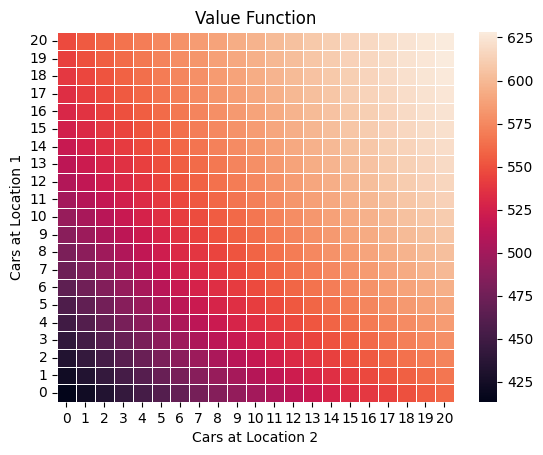

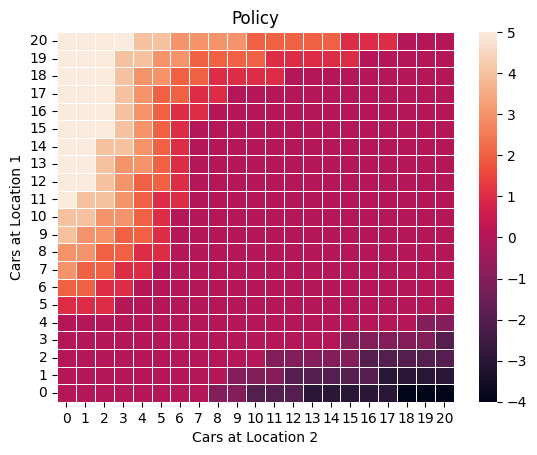

epsilon =  0.05
0.7818828680954084
0.37874901673762906
0.2764653228042562
0.23946757047451683
0.20102147030274864
0.16629312853501688
0.13684370686513603
0.11240630703576926
0.09226489483296518
0.0757032936169253
0.062099842919280945
0.050933067543894595
0.04177011566230249


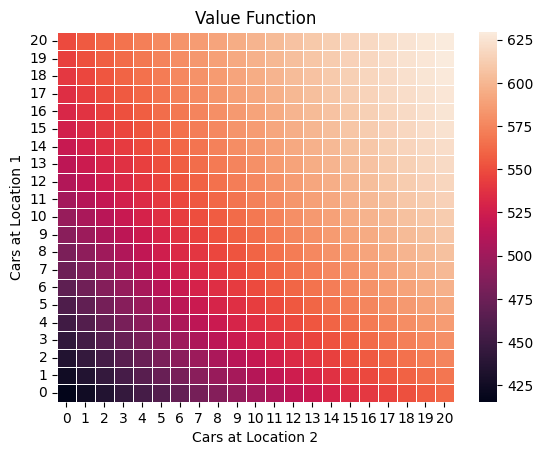

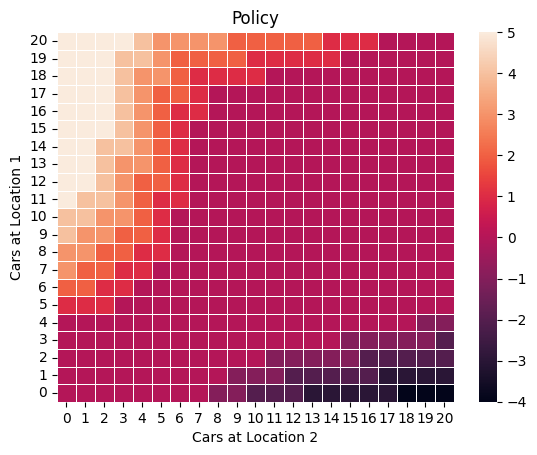

epsilon =  0.005000000000000001
0.04458665883737467
0.028088069228090262
0.02303183846424872
0.018885455994222866
0.01548538844616587
0.012697469661247851
0.010411575773957793
0.008537290004994702
0.007000437208318999
0.005740224176747688
0.004706838868344221


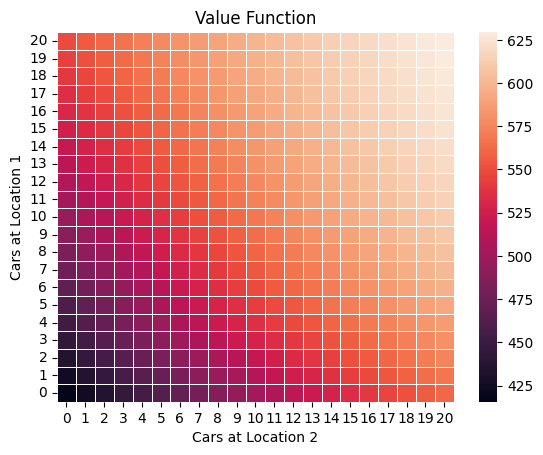

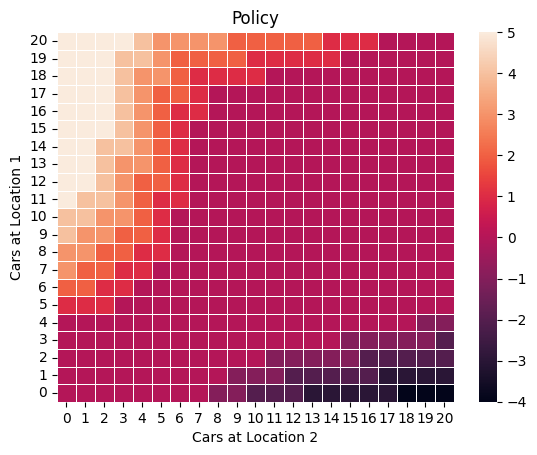

In [202]:
while(1):
  policy_eval()
  rho = policy_imp()
  value_plt()
  policy_plt()
  if rho == True:
    break

Exercise 4.7

In [219]:
value = np.zeros((jack.max_car()+1, jack.max_car()+1))
policy = value.copy().astype(int)
locA = loc(3,3)
locB = loc(4,2)
policy_plt.counter = 0
value_plt.counter = 0
policy_eval.epsilon = 50

epsilon =  50
169.90008661446743
119.08501115392252
81.88529858652623
64.74616803795362
51.78927693943126
40.39506710856176


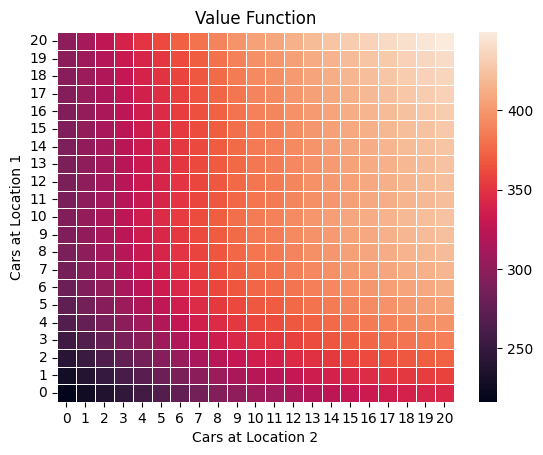

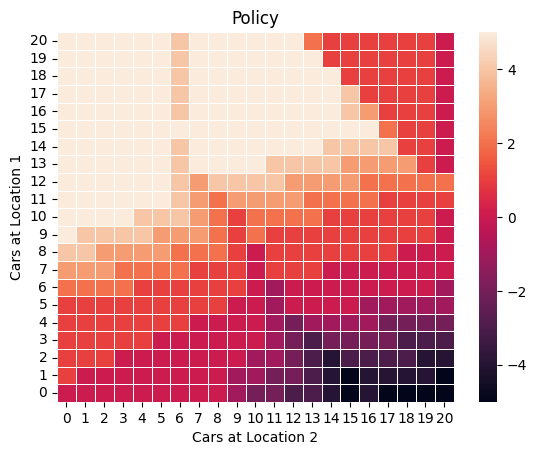

epsilon =  5.0
130.22573474640774
33.992001274082895
25.513755573927654
21.803711257235932
18.193578565608448
15.003757302147278
12.324400552542784
10.10948613854248
8.28763071782322
6.791937570776156
5.5651617331984085
4.559477221056341


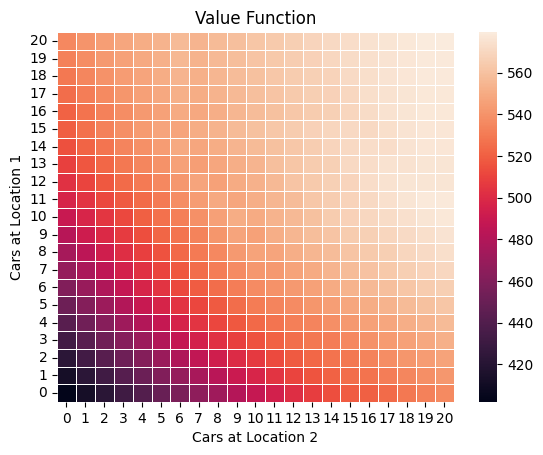

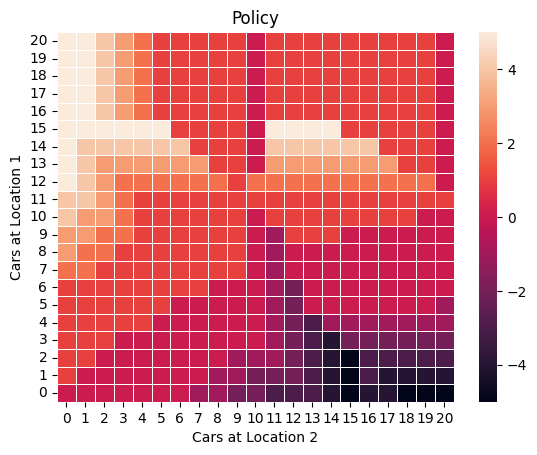

epsilon =  0.5
12.96200910728112
6.645207466001693
3.6468567344710436
2.4594042279103405
1.9803626503397709
1.556791763256001
1.2764536059793272
1.0510267391508137
0.8633221543225318
0.7081625047540001
0.5804264746624881
0.47550893404729777


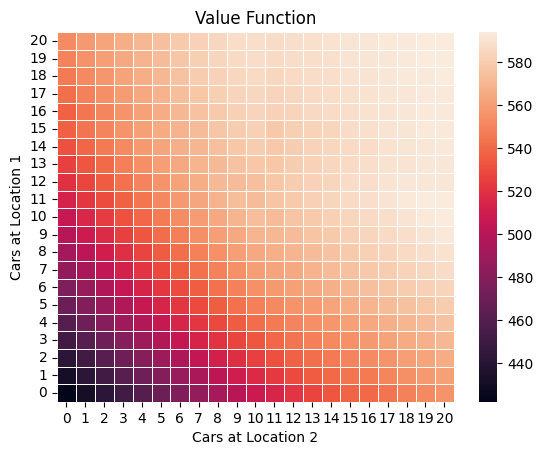

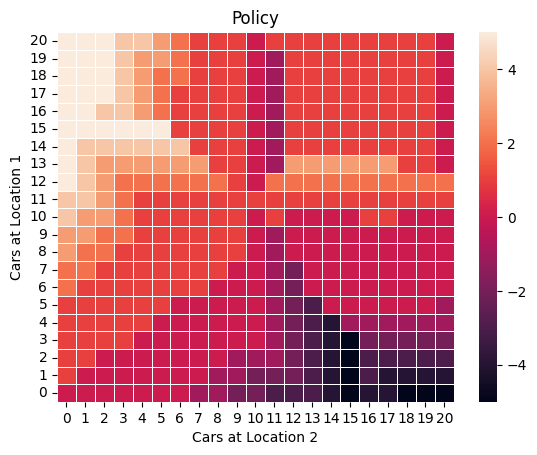

epsilon =  0.05
3.26015668939408
0.45167986933506654
0.26849425327594645
0.21972586165941266
0.1797746895782666
0.14718244083917398
0.12053995030146325
0.09872777648939746
0.08085784823072117
0.0662153500637146
0.05421864290963185
0.04439153050964251


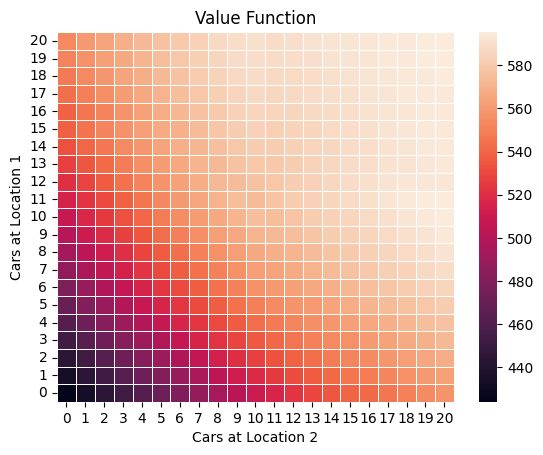

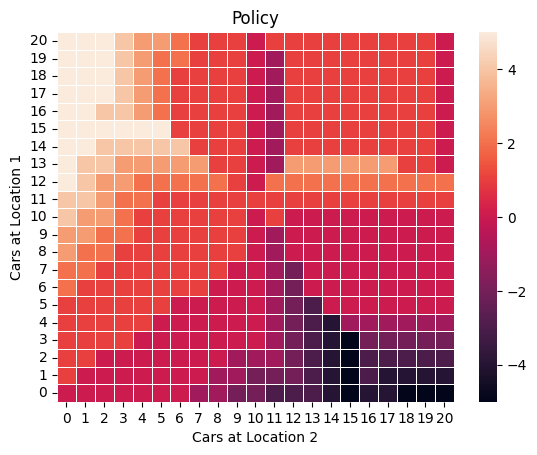

epsilon =  0.005000000000000001
0.05435185452608948
0.029752586395488834
0.02435982126246472
0.019954981657974713
0.01635152761707559
0.013396957785857921
0.010973020080541573
0.008985450207546819
0.007356772277603341
0.006022793419504069
0.0049304733692565605


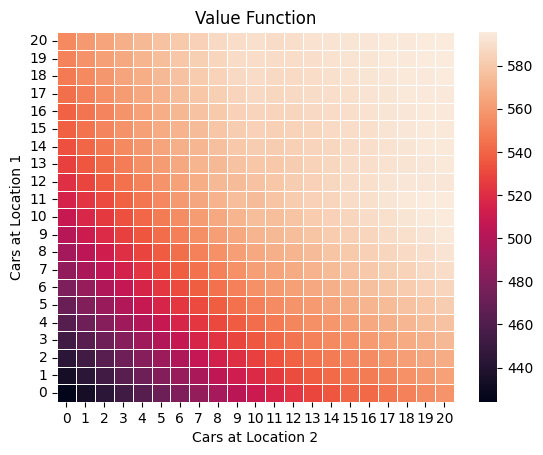

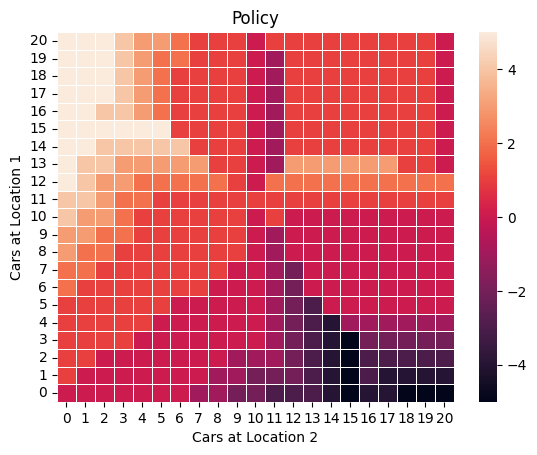

In [220]:
while(1):
  policy_eval_2()
  rho = policy_imp_2()
  value_plt()
  policy_plt()
  if rho == True:
    break